In [1]:
pip install flake8 pycodestyle_magic

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext pycodestyle_magic

In [3]:
%flake8_on

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Maintenance

Une fois notre modèle de segmentation choisi, nous allons étudier sa stabilité dans le temps. L'idée étant de savoir à quelle fréquence il serait nécessaire de mettre à jour notre segmentation afin de rester pertinente. 

Pour cela, nous allons calculer un **score ARI (Adjusted Rand Index)** mesurant la similarité entre deux jeux de données sur différentes périodes de temps et comparant les changements de clusters pour les clients. Ce score calculé est compris entre -1 et 1. Plus la valeur est proche de 1, plus la similarité est forte.

In [88]:
# On récupère notre dernier dataframe de clients
data = pd.read_csv('maintenance.csv', sep=';')
df = pd.read_csv('data_clients.csv', sep=';', index_col=0)

In [89]:
# On effectue un merge entre nos df afin d'avoir les dates d'achat

data = data
maint = pd.merge(data, df[['customer_unique_id', 'order_purchase_timestamp']],
                 on='customer_unique_id', how='left')

In [90]:
# Suppression des valeurs manquantes

maint = maint.dropna(subset='Distance')

On va maintenant évaluer la stabilité de notre modèle. 

On choisit une date T0 : 01-01-2017, et on regarde les dates situées avant celle-ci. 

In [91]:
# On convertit notre colonne en datetime
maint['order_purchase_timestamp'] = pd.to_datetime(
    maint['order_purchase_timestamp']
)
maint.dtypes

customer_unique_id                  object
Récence                              int64
Fréquence                            int64
Montant                            float64
Note_moyenne                       float64
Nombre_articles                    float64
payment_installments               float64
Distance                           float64
order_purchase_timestamp    datetime64[ns]
dtype: object

In [92]:
from datetime import datetime, timedelta

# On supprime les doublons
maint = maint.drop_duplicates()

# Sélection des données dont les dates sont situées avant la date
# T0 (01-01-2017)
T0 = datetime(2017, 1, 1)
df0 = maint[maint['order_purchase_timestamp'] <= T0]

In [93]:
# Création d'une liste de dates

dates = []

start_date = pd.to_datetime('2017-01-01')
end_date = start_date+timedelta(days=547)  # On prend sur 1 an et demi
delta = timedelta(days=15)  # On sélectionne un pas de 15 jours

while start_date < end_date:
    dates.append(start_date)
    start_date += delta

In [94]:
len(dates)

37

In [126]:
# Initialisation variables

T0 = dates[0]
df0 = maint[maint['order_purchase_timestamp'] <= T0].set_index(
    'customer_unique_id')
scaler = StandardScaler()
col = df0.drop('order_purchase_timestamp', axis=1).columns.tolist()
df0_scaled = pd.DataFrame(scaler.fit_transform(df0[col]), columns=col)
M0 = KMeans(n_init=10, n_clusters=8, random_state=42).fit(df0_scaled)
predictions = []
scores = []

# Boucle
for i in range(0, len(dates)):
    Ti = dates[i]
    dfi = maint[maint['order_purchase_timestamp'] <= Ti]
    # Standardisation
    dfi = dfi.set_index('customer_unique_id')
    col = dfi.drop('order_purchase_timestamp', axis=1).columns.tolist()
    scaler = StandardScaler()
    dfi_scaled = pd.DataFrame(scaler.fit_transform(dfi[col]), columns=col)
    # Entrainement du modèle sur Ti
    Mi = KMeans(n_init=10, n_clusters=8, random_state=42).fit(dfi_scaled)
    predictions.append(Mi.predict(dfi_scaled))
    # Calcul score ARI
    score = adjusted_rand_score(M0.predict(dfi_scaled), Mi.predict(dfi_scaled))
    scores.append(score)
    print(f"Score ARI entre T0 et T{i}: {score}")

Score ARI entre T0 et T0: 1.0
Score ARI entre T0 et T1: 0.9377420789794408
Score ARI entre T0 et T2: 0.8544999770835412
Score ARI entre T0 et T3: 0.8812117193960878
Score ARI entre T0 et T4: 0.8445331100320642
Score ARI entre T0 et T5: 0.88951542908783
Score ARI entre T0 et T6: 0.9013210041105522
Score ARI entre T0 et T7: 0.9016659016532339
Score ARI entre T0 et T8: 0.8973344602668015
Score ARI entre T0 et T9: 0.8989548758904325
Score ARI entre T0 et T10: 0.8952473072511605
Score ARI entre T0 et T11: 0.8924850954329535
Score ARI entre T0 et T12: 0.8859281020651197
Score ARI entre T0 et T13: 0.8827133966523599
Score ARI entre T0 et T14: 0.5724234846129237
Score ARI entre T0 et T15: 0.5691925401645693
Score ARI entre T0 et T16: 0.5630135379195375
Score ARI entre T0 et T17: 0.5529408049128611
Score ARI entre T0 et T18: 0.5429377781591886
Score ARI entre T0 et T19: 0.5391282398698226
Score ARI entre T0 et T20: 0.5334890752663665
Score ARI entre T0 et T21: 0.5279046392055644
Score ARI entre

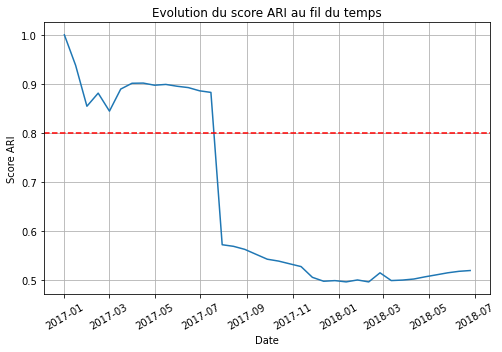

In [127]:
# Tracer le graphique
plt.figure(figsize=(8, 5))
plt.plot(dates, scores)
plt.axhline(y=0.8, color='red', linestyle='--')
plt.title("Evolution du score ARI au fil du temps")
plt.xlabel("Date")
plt.ylabel("Score ARI")
plt.grid()
plt.xticks(rotation=30)
plt.show()

Nous avons choisi de travailler sur une longue période de temps (1 an et demi) et d'observer l'évolution du Score ARI. Après calcul de ce score, on observe une certaine stabilisation (autour de 0.9) pendant environ 7 mois. Puis, une très forte chute est observée à partir du **mois d'août**. On passe à un score de 0.55 environ. Puis, au fil du temps, une stabilisation est observée aux alentours de 0.5. 

Cette observation permettent de stipuler qu'une **mise à jour tous les 7/8 mois** serait nécessaire afin de rester pertinente. 